# SCM DAG Generation

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings

# --- Helper functions for sampling from distributions ---

def sample_log_uniform(low, high, size=1, base=np.e):
    return np.power(base, np.random.uniform(np.log(low)/np.log(base), np.log(high)/np.log(base), size))

def sample_discretized_log_normal(mean, min_val, size=1):
    sigma = 0.8
    val = np.random.lognormal(mean=np.log(mean), sigma=sigma, size=size)
    return np.maximum(min_val, np.round(val)).astype(int)

def sample_exponential(scale, min_val, size=1):
    return min_val + np.round(np.random.exponential(scale=scale, size=size)).astype(int)

def generate_mlp_dropout_dag(num_nodes: int, num_layers: int, edge_dropout_prob: float = 0.2) -> nx.DiGraph:
    G = nx.DiGraph()
    nodes_per_layer_base = np.zeros(num_layers, dtype=int) + 1
    nodes_remaining = num_nodes - num_layers
    if nodes_remaining > 0:
        splits = np.sort(np.random.choice(nodes_remaining + num_layers - 1, num_layers - 1, replace=False))
        layer_sizes = np.diff(np.concatenate(([0], splits, [nodes_remaining + num_layers - 1]))) - 1
        nodes_per_layer_base += layer_sizes
    node_indices = np.arange(num_nodes)
    nodes_per_layer = np.split(node_indices, np.cumsum(nodes_per_layer_base)[:-1])
    for i, layer_nodes in enumerate(nodes_per_layer):
        for node in layer_nodes:
            G.add_node(node, layer=i)
    for i in range(num_layers - 1):
        for u in nodes_per_layer[i]:
            for v in nodes_per_layer[i+1]:
                if np.random.rand() > edge_dropout_prob:
                    G.add_edge(u, v)
    return G

def generate_scale_free_dag(num_nodes: int, m_edges: int = 2) -> nx.DiGraph:
    undirected_G = nx.barabasi_albert_graph(n=num_nodes, m=m_edges)
    G = nx.DiGraph()
    G.add_nodes_from(undirected_G.nodes())
    for u, v in undirected_G.edges():
        if u < v: G.add_edge(u, v)
        else: G.add_edge(v, u)
    for node in G.nodes():
        G.nodes[node]['layer'] = node % 5
    return G

def sample_dag_structure(config: dict) -> nx.DiGraph:
    graph_type = np.random.choice(config['graph_generation_method'])
    num_nodes = int(sample_log_uniform(config['num_nodes_low'], config['num_nodes_high'])[0])
    print(f"Generating a '{graph_type}' graph with {num_nodes} nodes")
    if graph_type == 'MLP-Dropout':
        num_layers = sample_discretized_log_normal(mean=config['mlp_num_layers_mean'], min_val=2)[0]
        return generate_mlp_dropout_dag(num_nodes=num_nodes, num_layers=num_layers)
    elif graph_type == 'Scale-Free':
        m_edges = np.random.randint(1, 5)
        return generate_scale_free_dag(num_nodes=num_nodes, m_edges=m_edges)



def softplus(x):
    return np.maximum(0, x) + np.log(1 + np.exp(-np.abs(x)))

SELU_LAMBDA = 1.0507
SELU_ALPHA = 1.67326

# Expanded dictionary of activation functions from the TabICL paper
ACTIVATION_FUNCTIONS = {
    'identity': lambda x: x,
    'tanh': np.tanh,
    'leaky_relu': lambda x: np.maximum(0.01 * x, x),
    'elu': lambda x: np.where(x > 0, x, 0.5 * (np.exp(x) - 1)),
    'silu': lambda x: x / (1 + np.exp(-x)),
    'sine': np.sin,
    'relu': lambda x: np.maximum(0, x),
    'relu6': lambda x: np.minimum(np.maximum(0, x), 6),
    'selu': lambda x: SELU_LAMBDA * np.where(x > 0, x, SELU_ALPHA * (np.exp(x) - 1)),
    'softplus': softplus,
    'hardtanh': lambda x: np.maximum(-1, np.minimum(1, x)),
    'sign': np.sign,
    'rbf': lambda x: np.exp(-np.square(x)),
    'exp': lambda x: np.exp(np.clip(x, -10, 10)), # Clipped for stability
    'sqrt_abs': lambda x: np.sqrt(np.abs(x)),
    'indicator_abs_le_1': lambda x: np.where(np.abs(x) <= 1, 1, 0),
    'square': np.square,
    'absolute': np.abs,
}

class RandomFourierFeatureFunction:
    """
    Implements the random function mechanism using Random Fourier Features. Internal parameters are sampled once upon initialization.
    """
    def __init__(self, N=256):
        # Sample parameters for the feature map phi once per instance of this class
        self.N = N
        u = np.random.uniform(0.7, 3.0)
        self.b = np.random.uniform(0, 2 * np.pi, N)
        self.a = np.random.uniform(0, N, N)
        # This weighting leads to different levels of smoothness
        self.w = self.a ** (-np.exp(u))

    def __call__(self, x: np.ndarray) -> np.ndarray:
        # x is a 1D array of input values
        # The random vector z is sampled for each call
        z = np.random.randn(self.N)

        # Ensure x is 2D for broadcasting
        if x.ndim == 1:
            x = x[:, np.newaxis]

        # phi(x) = (w / ||w||_2) * sin(ax + b)
        phi_x = (self.w / np.linalg.norm(self.w)) * np.sin(self.a * x + self.b)

        # f(x) = phi(x)^T z
        return np.dot(phi_x, z)

def assign_functional_mechanisms(dag: nx.DiGraph, config: dict):
    """
    Assigns a computational function to each node,
    """
    function_choices = config['scm_activation_functions'] + ['random_fourier']

    for node in dag.nodes():
        choice = np.random.choice(function_choices)

        # Determine if the node should be simple SCM, tree, or random fourier
        if choice != 'random_fourier' and np.random.rand() < config['function_type_mixture_ratio']:
            func_name = np.random.choice(config['scm_activation_functions'])
            parents = list(dag.predecessors(node))
            dag.nodes[node].update({
                'type': 'scm', 'function_name': func_name,
                'function': ACTIVATION_FUNCTIONS[func_name],
                'weights': np.random.randn(len(parents)), 'bias': np.random.randn()
            })
        elif choice == 'random_fourier':
            parents = list(dag.predecessors(node))
            dag.nodes[node].update({
                'type': 'random_fourier', 'function_name': 'RandomFourierFunc',
                'function': RandomFourierFeatureFunction(),
                # This function type operates on a single parent's output
                'parent_selector': np.random.randint(len(parents)) if parents else None
            })
        else: # Tree-based
            params = {
                'n_estimators': sample_exponential(config['xgb_n_estimators_exp_scale'], 1)[0],
                'max_depth': sample_exponential(config['xgb_max_depth_exp_scale'], 2)[0],
                'n_jobs': 1
            }
            model = xgb.XGBRegressor(**params)
            dag.nodes[node].update({
                'type': 'tree', 'function_name': 'XGBoost',
                'function': model, 'params': params
            })

Generating a 'MLP-Dropout' graph with 29 nodes

Node 0:
  - Mechanism Type: scm
  - Function: tanh
  - Number of Weights: 0
  - Bias value: -0.18

Node 1:
  - Mechanism Type: tree
  - Function: XGBoost
  - XGBoost Params: {'n_estimators': 1, 'max_depth': 2, 'n_jobs': 1}

Node 2:
  - Mechanism Type: tree
  - Function: XGBoost
  - XGBoost Params: {'n_estimators': 1, 'max_depth': 3, 'n_jobs': 1}

Node 3:
  - Mechanism Type: tree
  - Function: XGBoost
  - XGBoost Params: {'n_estimators': 1, 'max_depth': 2, 'n_jobs': 1}

Node 4:
  - Mechanism Type: tree
  - Function: XGBoost
  - XGBoost Params: {'n_estimators': 2, 'max_depth': 2, 'n_jobs': 1}

Node 5:
  - Mechanism Type: scm
  - Function: hardtanh
  - Number of Weights: 0
  - Bias value: -1.29

Node 6:
  - Mechanism Type: scm
  - Function: square
  - Number of Weights: 0
  - Bias value: 1.20

Node 7:
  - Mechanism Type: scm
  - Function: rbf
  - Number of Weights: 3
  - Bias value: 0.10

Node 8:
  - Mechanism Type: scm
  - Function: sign
  

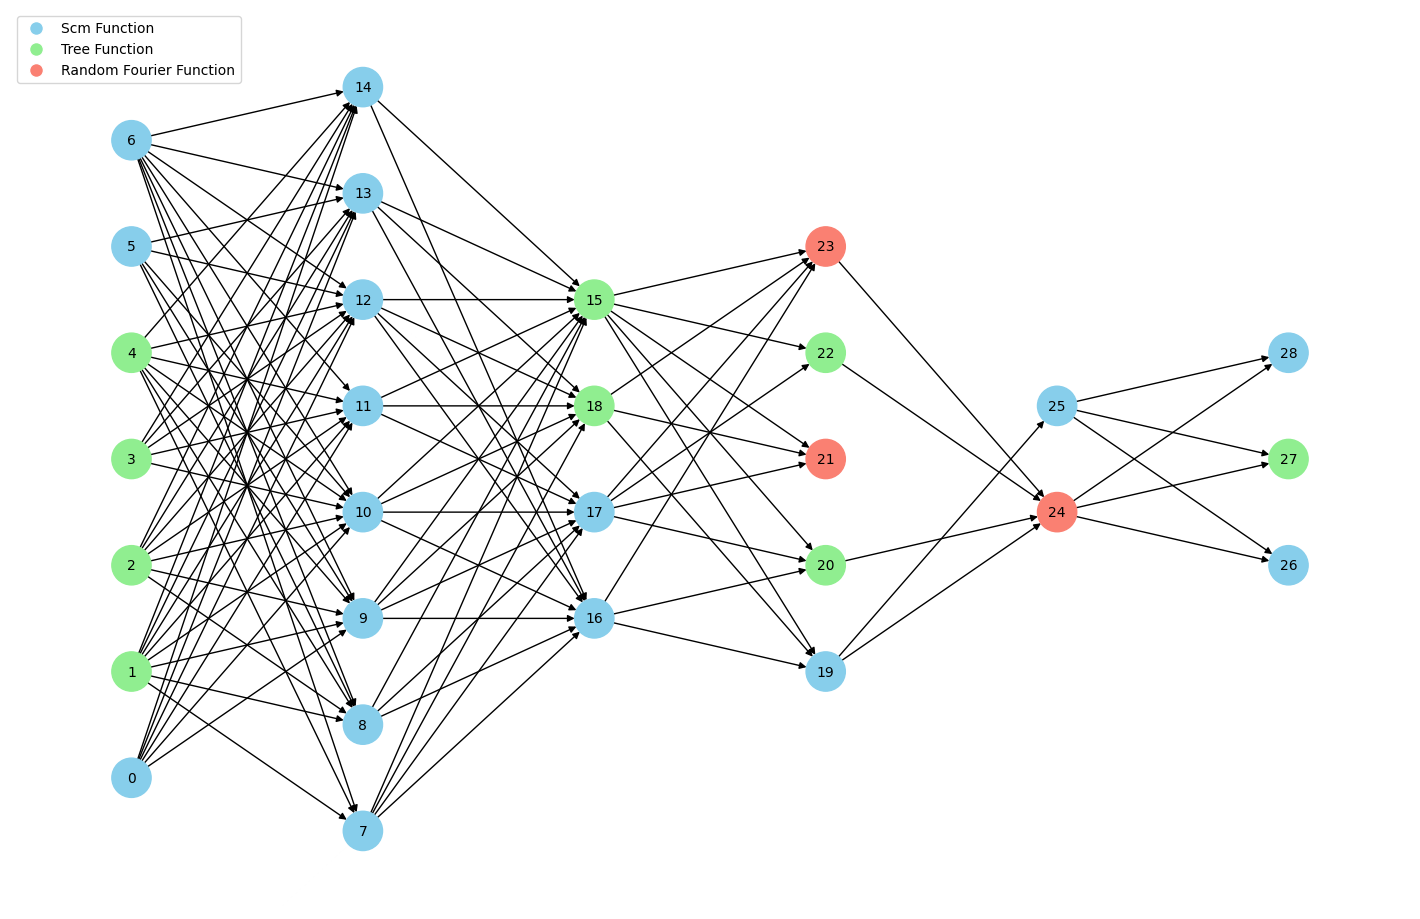

In [3]:
config = {
    'graph_generation_method': ['MLP-Dropout'],
    'num_nodes_low': 15,
    'num_nodes_high': 30,
    'mlp_num_layers_mean': 4,
    'function_type_mixture_ratio': 0.7, # 70% SCMs or Random Fourier, 30% Tree-based
    'scm_activation_functions': list(ACTIVATION_FUNCTIONS.keys()),
    'xgb_n_estimators_exp_scale': 0.5,
    'xgb_max_depth_exp_scale': 0.5,
}

# --- Generate a sample DAG ---
test_dag = sample_dag_structure(config)

# --- Run the updated function to assign mechanisms ---
assign_functional_mechanisms(test_dag, config)


# --- just verifying ---
for node_id, data in test_dag.nodes(data=True):
    mechanism_type = data.get('type')
    func_name = data.get('function_name')

    print(f"\nNode {node_id}:")
    print(f"  - Mechanism Type: {mechanism_type}")
    print(f"  - Function: {func_name}")

    if mechanism_type == 'scm':
        print(f"  - Number of Weights: {len(data.get('weights', []))}")
        print(f"  - Bias value: {data.get('bias', 'N/A'):.2f}")
    elif mechanism_type == 'tree':
        print(f"  - XGBoost Params: {data.get('params', {})}")
    elif mechanism_type == 'random_fourier':
        print(f"  - Function Object: {data.get('function')}")


# Check that a mix of mechanism types were assigned
types_assigned = {data.get('type') for _, data in test_dag.nodes(data=True)}
print(f"\nmechanism types assigned to graph: {types_assigned}")

# Visualize
plt.figure(figsize=(14, 9))
pos = nx.multipartite_layout(test_dag, subset_key='layer')

color_map = {'scm': 'skyblue', 'tree': 'lightgreen', 'random_fourier': 'salmon'}
colors = [color_map.get(data.get('type', 'scm')) for _, data in test_dag.nodes(data=True)]

nx.draw(test_dag, pos, with_labels=True, node_size=800, node_color=colors, font_size=10, arrows=True)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'{mech_type.replace("_", " ").title()} Function',
                             markerfacecolor=color, markersize=10) for mech_type, color in color_map.items()]
plt.legend(handles=legend_handles, loc='upper left')

plt.show()

Generating a 'Scale-Free' graph with 38 nodes
Node 0: Type='random_fourier', Function='RandomFourierFunc'
Node 1: Type='scm', Function='selu'
Node 2: Type='tree', Function='XGBoost'
Node 3: Type='scm', Function='hardtanh'
Node 4: Type='random_fourier', Function='RandomFourierFunc'
Node 5: Type='scm', Function='elu'
Node 6: Type='scm', Function='sine'
Node 7: Type='tree', Function='XGBoost'
Node 8: Type='scm', Function='identity'
Node 9: Type='scm', Function='sign'
Node 10: Type='scm', Function='elu'
Node 11: Type='scm', Function='sine'
Node 12: Type='scm', Function='tanh'
Node 13: Type='scm', Function='square'
Node 14: Type='scm', Function='softplus'
Node 15: Type='scm', Function='relu'
Node 16: Type='scm', Function='selu'
Node 17: Type='random_fourier', Function='RandomFourierFunc'
Node 18: Type='scm', Function='elu'
Node 19: Type='tree', Function='XGBoost'
Node 20: Type='scm', Function='softplus'
Node 21: Type='tree', Function='XGBoost'
Node 22: Type='tree', Function='XGBoost'
Node 2

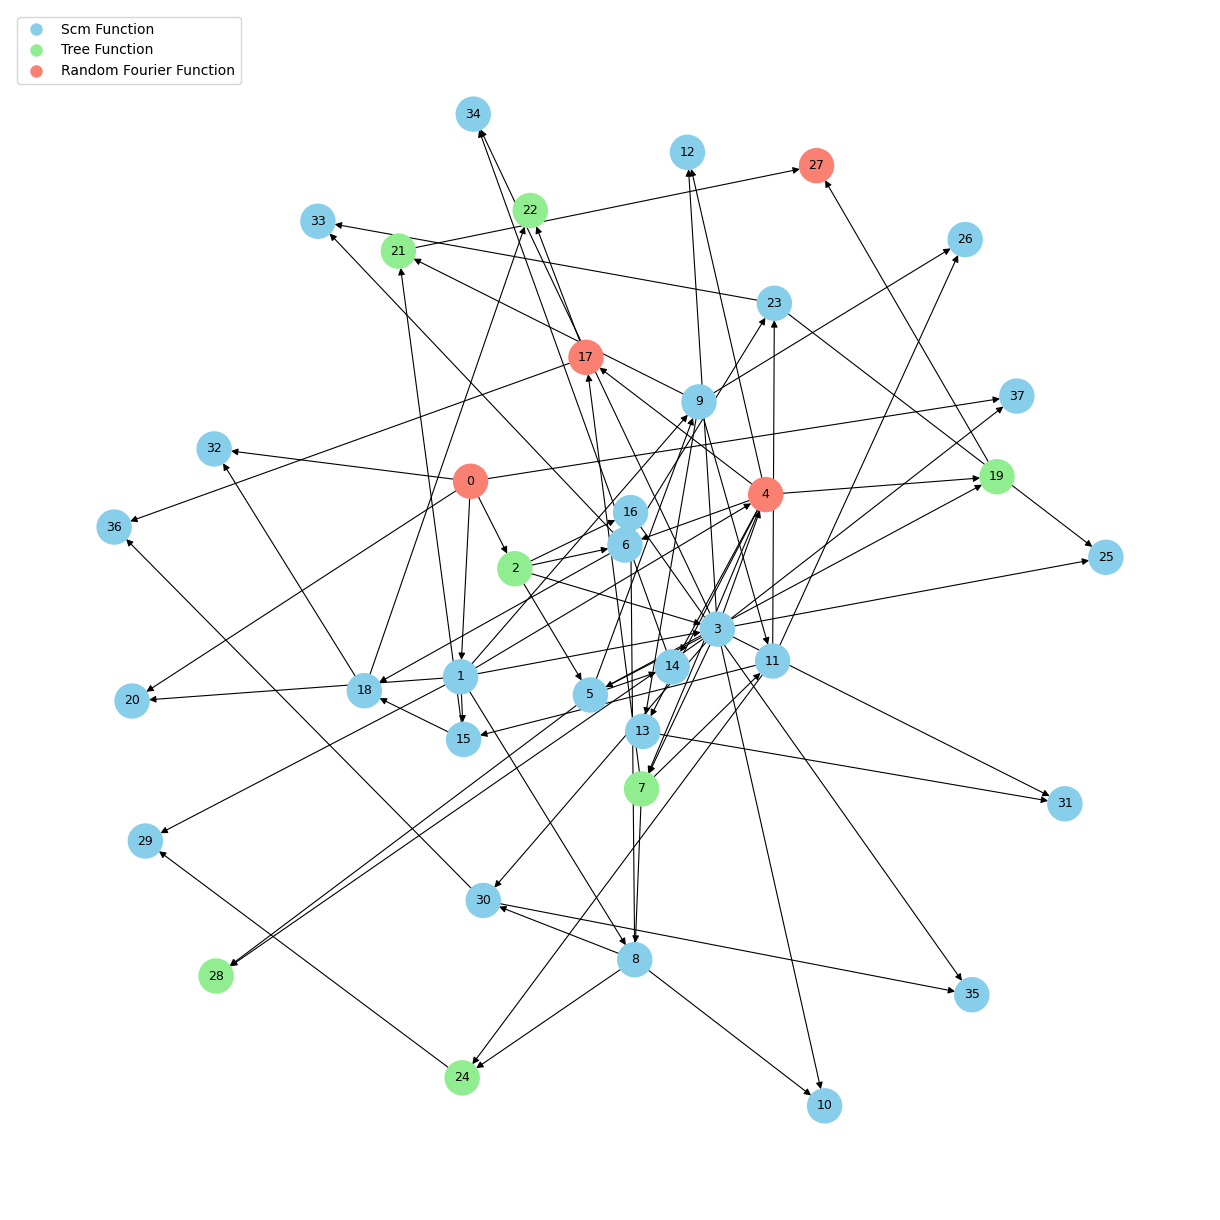

In [4]:
config = {
    'graph_generation_method': ['MLP-Dropout', 'Scale-Free'],
    'num_nodes_low': 20,
    'num_nodes_high': 50,
    'mlp_num_layers_mean': 5,
    'function_type_mixture_ratio': 0.7, # 70% SCMs or Random Fourier, 30% Tree-based
    'scm_activation_functions': list(ACTIVATION_FUNCTIONS.keys()),
    'xgb_n_estimators_exp_scale': 0.5,
    'xgb_max_depth_exp_scale': 0.5,
}

# --- Force generation of a Scale-Free DAG for this test ---
sf_test_config = config.copy()
sf_test_config['graph_generation_method'] = ['Scale-Free']
sf_test_dag = sample_dag_structure(sf_test_config)

assign_functional_mechanisms(sf_test_dag, config)


# --- verifying again ---
for node_id, data in sf_test_dag.nodes(data=True):
    mechanism_type = data.get('type')
    func_name = data.get('function_name')
    print(f"Node {node_id}: Type='{mechanism_type}', Function='{func_name}'")

types_assigned = {data.get('type') for _, data in sf_test_dag.nodes(data=True)}
print(f"\nmechanism types assigned to graph: {types_assigned}")


# --- Visualization ---
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(sf_test_dag, seed=42, k=0.8)

color_map = {'scm': 'skyblue', 'tree': 'lightgreen', 'random_fourier': 'salmon'}
colors = [color_map.get(data.get('type', 'scm')) for _, data in sf_test_dag.nodes(data=True)]

nx.draw(sf_test_dag, pos, with_labels=True, node_size=600, node_color=colors, font_size=9, arrows=True, width=0.8)

legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'{mech_type.replace("_", " ").title()} Function',
                             markerfacecolor=color, markersize=10) for mech_type, color in color_map.items()]
plt.legend(handles=legend_handles, loc='upper left')

plt.show()

# Data Propagation and Matrix Generation

In [5]:
import pandas as pd

def generate_complete_matrix(config: dict) -> pd.DataFrame:
    """Generates a single, complete n x m matrix using the full SCM process."""
    dag = sample_dag_structure(config)
    assign_functional_mechanisms(dag, config)
    n_rows = int(sample_log_uniform(config['num_rows_low'], config['num_rows_high'])[0])
    sorted_nodes = list(nx.topological_sort(dag))
    node_data = {node: np.zeros(n_rows) for node in sorted_nodes}

    for node in sorted_nodes:
        parents = list(dag.predecessors(node))
        node_info = dag.nodes[node]
        if not parents:
            noise_type = np.random.choice(config['root_node_noise_dist'])
            if noise_type == 'Normal':
                node_data[node] = np.random.randn(n_rows)
            elif noise_type == 'Uniform':
                node_data[node] = np.random.uniform(-1, 1, n_rows)
        else:
            parent_values = np.vstack([node_data[p] for p in parents]).T
            if node_info['type'] == 'scm':
                linear_combination = np.dot(parent_values, node_info['weights']) + node_info['bias']
                node_data[node] = node_info['function'](linear_combination)
            elif node_info['type'] == 'random_fourier':
                selected_parent_data = parent_values[:, node_info['parent_selector']]
                node_data[node] = node_info['function'](selected_parent_data)
            elif node_info['type'] == 'tree':
                fake_targets = np.random.randn(n_rows)
                node_info['function'].fit(parent_values, fake_targets)
                node_data[node] = node_info['function'].predict(parent_values)

    num_scm_nodes = dag.number_of_nodes()
    m_cols = np.random.randint(config['num_cols_low'], min(num_scm_nodes + 1, config['num_cols_high']))
    final_cols = np.random.choice(list(node_data.keys()), m_cols, replace=False)
    matrix = pd.DataFrame({f"feature_{col}": node_data[col] for col in final_cols})

    if np.random.rand() < config['apply_feature_warping_prob']:
        print("Feature Warping with Beta Distribution")
        scaler = MinMaxScaler()
        for col in matrix.columns:
            # Scale data to [0, 1] range required by Beta
            col_data = scaler.fit_transform(matrix[[col]])

            # Sample shape parameters (alpha and beta) for the Beta
            a, b = np.random.rand() * 5 + 0.5, np.random.rand() * 5 + 0.5

            # Clip to avoid issues with 0 and 1
            epsilon = 1e-10
            clipped_data = np.clip(col_data, epsilon, 1 - epsilon)
            warped_data = beta.ppf(clipped_data, a, b)

            # Scale back to original range
            matrix[col] = scaler.inverse_transform(warped_data.reshape(-1, 1)).flatten()

    if np.random.rand() < config['apply_quantization_prob']:
        col_to_quantize = np.random.choice(matrix.columns)
        num_bins = np.random.randint(2, 20)
        try:
            matrix[col_to_quantize] = pd.qcut(matrix[col_to_quantize], q=num_bins, labels=False, duplicates='drop')
        except ValueError:
            pass # Ignore if quantization fails

    return matrix

In [5]:
config = {
    # Graph Structure
    'graph_generation_method': ['MLP-Dropout', 'Scale-Free'],
    'num_nodes_low': 20,
    'num_nodes_high': 100,
    'mlp_num_layers_mean': 6,

    # Functional Mechanisms
    'function_type_mixture_ratio': 0.7,
    'scm_activation_functions': list(ACTIVATION_FUNCTIONS.keys()),
    'xgb_n_estimators_exp_scale': 0.5,
    'xgb_max_depth_exp_scale': 0.5,

    # Data Generation
    'num_rows_low': 50,
    'num_rows_high': 1000,
    'num_cols_low': 5,
    'num_cols_high': 50,
    'root_node_noise_dist': ['Normal', 'Uniform'],

    # Post-processing
    'apply_feature_warping_prob': 0.1,
    'apply_quantization_prob': 0.1,
}

# Generate and Verify 1 Complete Matrix ---
final_matrix = generate_complete_matrix(config)

print(f"Final Matrix Shape: {final_matrix.shape}")
print("Data Types:\n", final_matrix.dtypes)
display(final_matrix.head())

# Check for obvs errors
assert not final_matrix.isnull().values.any(), "Matrix contains unexpected NaNs"
assert final_matrix.shape[0] > 0 and final_matrix.shape[1] > 0, "Matrix is empty"

Generating a 'Scale-Free' graph with 31 nodes
Final Matrix Shape: (382, 13)
Data Types:
 feature_25    float64
feature_24    float64
feature_18    float32
feature_13    float64
feature_3     float32
feature_1       int64
feature_0     float64
feature_11      int64
feature_16    float64
feature_15    float64
feature_6     float32
feature_30    float64
feature_4     float32
dtype: object


,feature_25,feature_24,feature_18,feature_13,feature_3,feature_1,feature_0,feature_11,feature_16,feature_15,feature_6,feature_30,feature_4
0,3.527722,1.404343,-0.005688,-0.003898,0.009271,1,0.238153,0,-1.0,1.708835,0.066309,-1.261404,-0.022102
1,2.493967,0.829767,-0.005688,-0.006984,0.009271,1,-0.768221,0,-1.0,1.071551,0.005727,1.260616,0.100514
2,3.043301,1.257227,-0.005688,-0.004053,0.009271,1,0.000145,0,-1.0,1.186157,0.066309,-0.048724,-0.022102
3,2.773927,1.045494,-0.005688,-0.005485,0.009271,1,-0.367897,0,-1.0,1.079168,0.066309,0.683589,-0.022102
4,3.463773,1.385088,-0.005688,-0.004145,0.009271,1,0.204657,0,-1.0,1.630327,0.066309,-1.090908,-0.022102


# Inducing Controlled Missingness on Matrices

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def _logit(x):
    """ need to convert log-odds to probs"""
    return 1 / (1 + np.exp(-x))

def induce_mcar(matrix: pd.DataFrame, p: float):
    """Induces MCAR values."""
    mat = matrix.copy()
    mask = np.random.rand(*mat.shape) < p
    mat[mask] = np.nan
    return mat

def induce_mar(matrix: pd.DataFrame, p: float):
    """Induces MAR values."""
    mat = matrix.copy()
    num_predictors = np.random.randint(1, max(2, mat.shape[1] // 2))
    predictor_cols = mat.sample(n=num_predictors, axis=1).columns
    target_cols = mat.columns.difference(predictor_cols)
    betas = np.random.randn(len(predictor_cols))
    log_odds = np.dot(mat[predictor_cols].fillna(0), betas)
    beta_0 = -np.quantile(log_odds, 1 - p)
    probs = _logit(log_odds + beta_0)
    for col in target_cols:
        mask = np.random.rand(len(mat)) < probs
        mat.loc[mask, col] = np.nan
    return mat

def induce_mnar(matrix: pd.DataFrame, p: float):
    """Induces MNAR values based on the column's own values."""
    mat = matrix.copy()
    target_cols = mat.sample(n=np.random.randint(1, mat.shape[1] + 1), axis=1).columns
    for col in target_cols:
        beta_1 = np.random.choice([-2, -1, 1, 2])
        log_odds = mat[col] * beta_1
        beta_0 = -np.quantile(log_odds.dropna(), 1 - p) if not log_odds.isnull().all() else 0
        probs = _logit(log_odds + beta_0)
        mask = np.random.rand(len(mat)) < probs
        mat.loc[mask, col] = np.nan
    return mat


def induce_mnar_rec_system(matrix: pd.DataFrame, n_core_items: int, n_genres: int) -> pd.DataFrame:
    """
    Induces block-sparse MNAR pattern typical of recommender systems.
    - A subset of 'core' items are observed more frequently
    - Other items belong to genres and users only rate items from their favorite genre.
    """
    mat = matrix.copy()
    n_users, n_items = mat.shape

    if n_core_items >= n_items:
        warnings.warn("n_core_items is >= n_items. Returning dense matrix for core items.")
        return mat

    # Assign genres to non-core items and users
    item_genres = np.random.randint(0, n_genres, n_items - n_core_items)
    user_favorite_genres = np.random.randint(0, n_genres, n_users)

    # Create a mask. Start with all missing.
    mask = np.full(mat.shape, False)

    # Core items are always observed
    mask[:, :n_core_items] = True

    # Users observe items of their favorite genre
    for i in range(n_users):
        user_genre = user_favorite_genres[i]
        # Find which non-core items match the user's favorite genre
        matching_items_indices = np.where(item_genres == user_genre)[0] + n_core_items
        if len(matching_items_indices) > 0:
            mask[i, matching_items_indices] = True

    mat[~mask] = np.nan
    return mat

def induce_mnar_panel_data(matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Induces MNAR pattern typical of panel data (like synthetic controls).
    For each unit/row , data is observed until a treatment time, then goes missing.
    """
    mat = matrix.copy()
    n_users, n_timesteps = mat.shape

    # Each user gets a random "treatment" time
    treatment_times = np.random.randint(1, n_timesteps, size=n_users)

    for i in range(n_users):
        mat.iloc[i, treatment_times[i]:] = np.nan

    return mat

def induce_mnar_sequential_decision(matrix: pd.DataFrame, n_policies: int) -> pd.DataFrame:
    """
    Induces MNAR pattern for sequential decision-making. At each time stepp,
    only one of several possible policies/columns is observed for each unit.
    Assumes columns are grouped by time like [t1p1, t1p2, t2p1, t2p2, ...].
    """
    mat = matrix.copy()
    n_users, n_cols = mat.shape

    if n_cols % n_policies != 0:
        # Trim the matrix to be compatible
        n_cols_to_keep = (n_cols // n_policies) * n_policies
        if n_cols_to_keep == 0:
          warnings.warn(f"Number of columns ({n_cols}) is not divisible by n_policies ({n_policies}). "
                      f"Trimming matrix to {n_cols_to_keep} columns.")
        mat = mat.iloc[:, :n_cols_to_keep]
        n_cols = n_cols_to_keep


    n_timesteps = n_cols // n_policies
    mask = np.full(mat.shape, False)

    for i in range(n_users):
        for t in range(n_timesteps):
            # For each user at each timestep, choose one policy to observe
            observed_policy_idx = np.random.randint(0, n_policies)
            col_idx = t * n_policies + observed_policy_idx
            mask[i, col_idx] = True

    mat[~mask] = np.nan
    return mat

def induce_mnar_polarization(matrix: pd.DataFrame, threshold_quantile: float = 0.2):
    """
    Induces an MNAR pattern simulating polarization that Abhi was talking about. only "extreme"
    values (in the tails of the distribution) are observed, and neutral
    values in the middle are set to NaN.
    """

    mat = matrix.copy()
    for col in mat.columns:
        # Skip if column is constant or has many NaNs already, as quantiles would be meaningless
        if mat[col].nunique() < 2 or mat[col].isnull().all():
            continue

        # Calculate quantile thresholds
        lower_bound = mat[col].quantile(threshold_quantile)
        upper_bound = mat[col].quantile(1 - threshold_quantile)

        # If bounds are the same, we can't create a middle ground to remove
        if lower_bound == upper_bound:
            continue

        # Create a mask for values that are NOT in the tails (i.e., are in the middle)
        mask_middle = (mat[col] > lower_bound) & (mat[col] < upper_bound)

        # Apply the mask to set middle values to NaN
        mat.loc[mask_middle, col] = np.nan

    return mat


Generating a complete matrix
Generating a 'MLP-Dropout' graph with 43 nodes
Generated a complete matrix of shape: (134, 15)


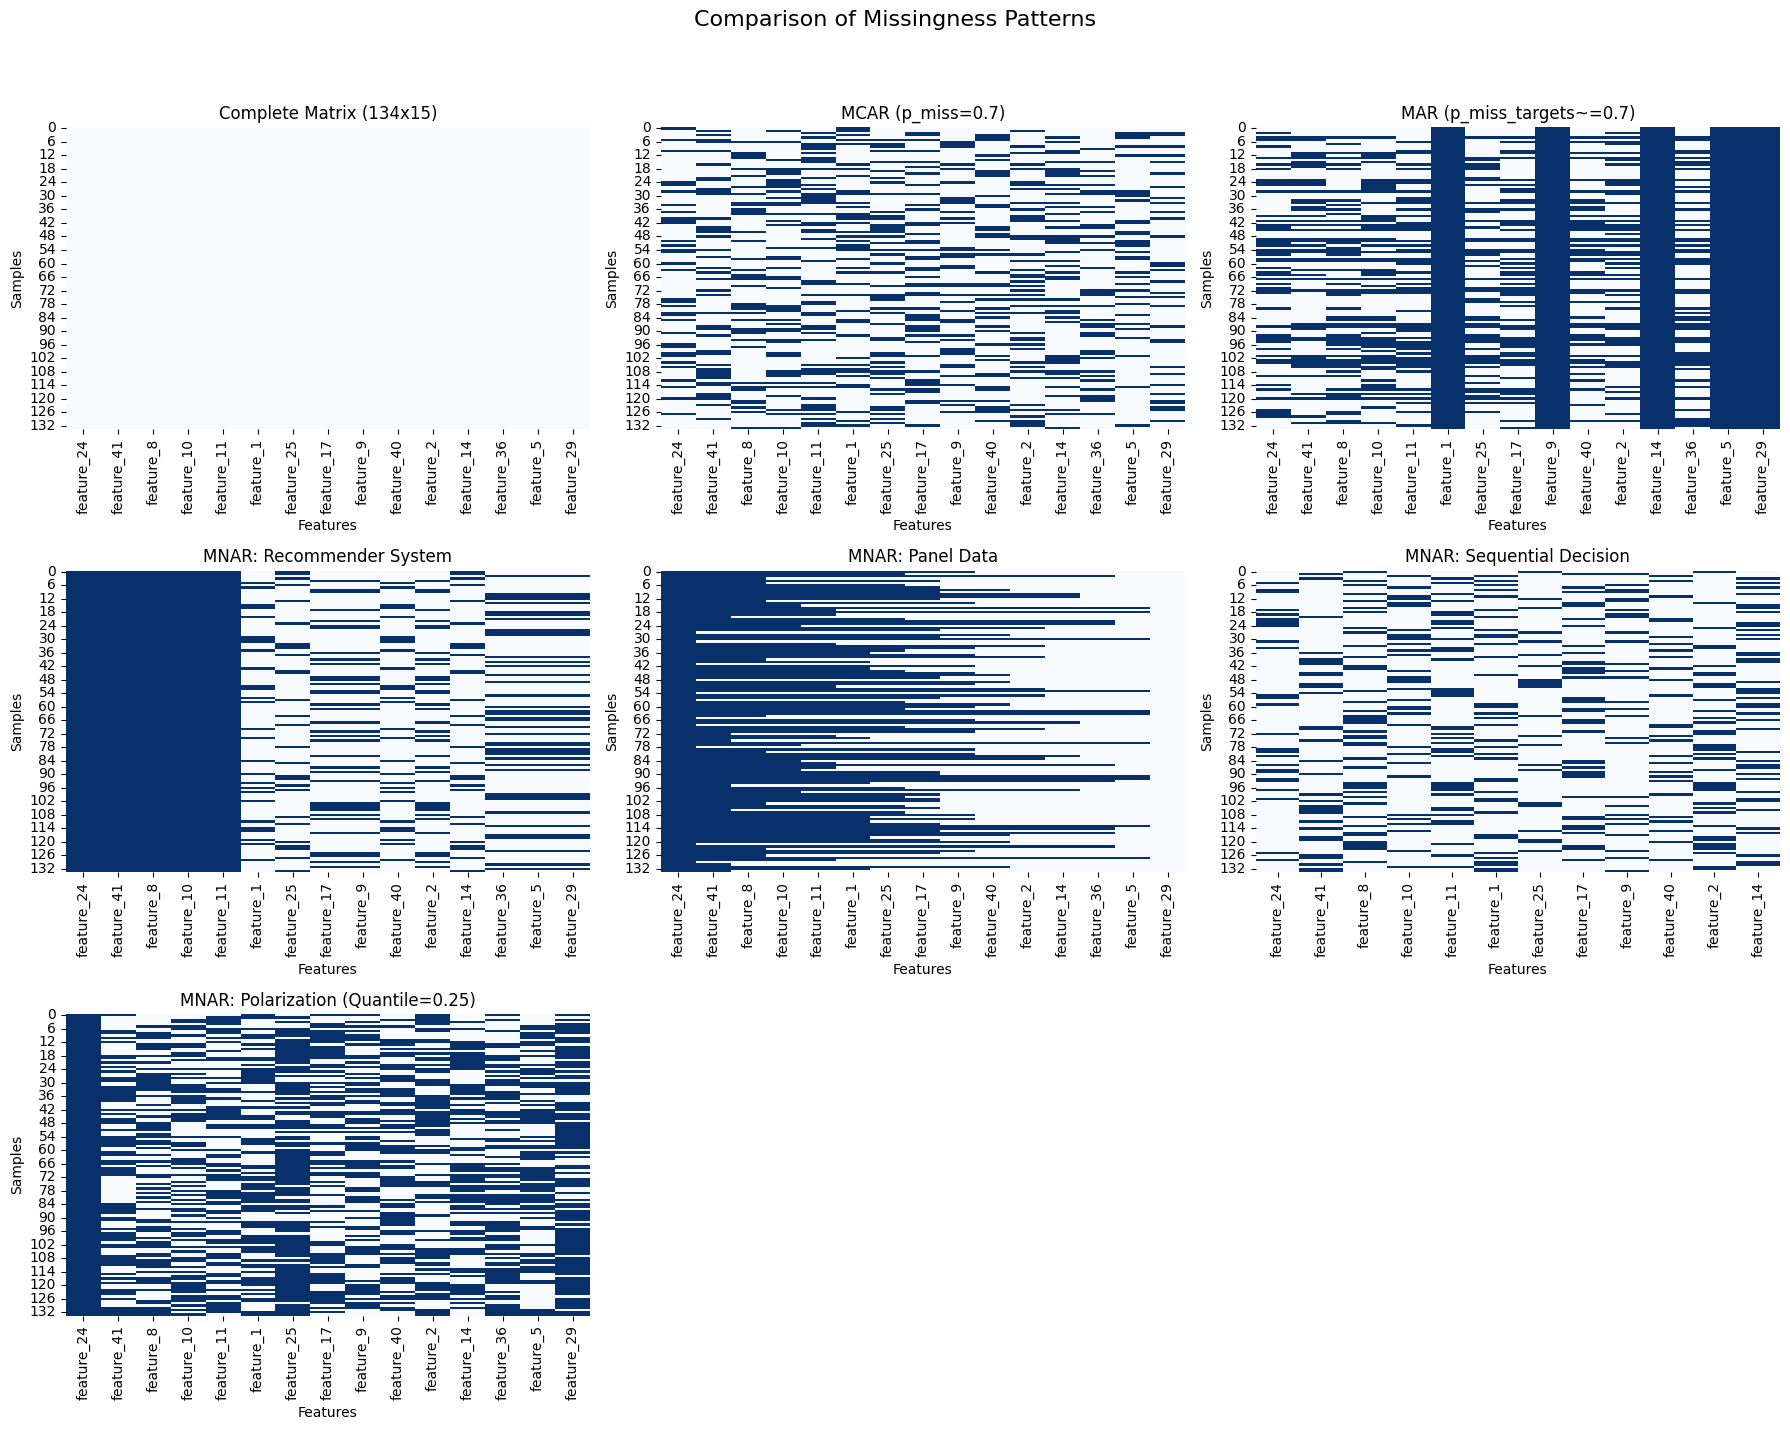

In [14]:
if __name__ == '__main__':
    # config for matrix generation
    config = {
        'graph_generation_method': ['MLP-Dropout'], 'num_nodes_low': 40, 'num_nodes_high': 50,
        'mlp_num_layers_mean': 5, 'function_type_mixture_ratio': 0.7,
        'scm_activation_functions': list(ACTIVATION_FUNCTIONS.keys()), 'xgb_n_estimators_exp_scale': 0.5,
        'xgb_max_depth_exp_scale': 0.5, 'num_rows_low': 50, 'num_rows_high': 200,
        'num_cols_low': 5, 'num_cols_high': 20, 'root_node_noise_dist': ['Normal', 'Uniform'],
        'apply_feature_warping_prob': 0.0, 'apply_quantization_prob': 0.0,
    }

    # Generate complete matrix
    print("Generating a complete matrix")
    complete_df = generate_complete_matrix(config)
    print(f"Generated a complete matrix of shape: {complete_df.shape}")

    # different missingness patterns
    p_missing = 0.7
    mcar_df = induce_mcar(complete_df, p=p_missing)
    mar_df = induce_mar(complete_df, p=p_missing)
    rec_sys_df = induce_mnar_rec_system(complete_df, n_core_items=5, n_genres=4)
    panel_df = induce_mnar_panel_data(complete_df)
    seq_dec_df = induce_mnar_sequential_decision(complete_df, n_policies=4)
    # --- Use the new polarization function ---
    polarization_df = induce_mnar_polarization(complete_df, threshold_quantile=0.25)


    # Viz
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Comparison of Missingness Patterns', fontsize=16)

    ax = axes.ravel()

    sns.heatmap(complete_df.notna(), ax=ax[0], cbar=False, cmap='Blues')
    ax[0].set_title(f'Complete Matrix ({complete_df.shape[0]}x{complete_df.shape[1]})')

    sns.heatmap(mcar_df.notna(), ax=ax[1], cbar=False, cmap='Blues')
    ax[1].set_title(f'MCAR (p_miss={p_missing})')

    sns.heatmap(mar_df.notna(), ax=ax[2], cbar=False, cmap='Blues')
    ax[2].set_title(f'MAR (p_miss_targets~={p_missing})')

    sns.heatmap(rec_sys_df.notna(), ax=ax[3], cbar=False, cmap='Blues')
    ax[3].set_title('MNAR: Recommender System')

    sns.heatmap(panel_df.notna(), ax=ax[4], cbar=False, cmap='Blues')
    ax[4].set_title('MNAR: Panel Data')

    sns.heatmap(seq_dec_df.notna(), ax=ax[5], cbar=False, cmap='Blues')
    ax[5].set_title(f'MNAR: Sequential Decision')

    # --- Plot the new pattern ---
    sns.heatmap(polarization_df.notna(), ax=ax[6], cbar=False, cmap='Blues')
    ax[6].set_title('MNAR: Polarization (Quantile=0.25)')

    # Turn off unused axes
    ax[7].axis('off')
    ax[8].axis('off')

    for i in range(7):
        ax[i].set_xlabel('Features')
        ax[i].set_ylabel('Samples')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [15]:
mcar_df.to_numpy()

array([[-0.05196381,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,  1.51025925,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
        -0.20097834,  1.        ],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
         0.71581442,         nan],
       [        nan,         nan,  1.02207201, ...,         nan,
                nan,         nan]])

In [16]:
from mcpfn.utils import create_train_test_sets

train_X, train_y, test_X, test_y = create_train_test_sets(mcar_df.to_numpy(), X_full=complete_df.to_numpy())

In [17]:
# Get range of numpy array

print(np.min(train_y), np.max(train_y))

-3.2279454565515673 421857893.4497753


In [18]:
print(np.min(test_y), np.max(test_y))

-2.7346820679363475 421474934.68597203


In [13]:
mcar_df.shape, train_X.shape

((159, 29), (1356, 186))

# Benchmark Data Generator

In [8]:
import random
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import beta
import warnings

In [14]:
def generate_training_set(num_matrices: int, num_features: int) -> list[pd.DataFrame]:
    generated_matrices = []

    config = {
        'graph_generation_method': ['MLP-Dropout', 'Scale-Free'],
        'num_nodes_low': num_features,
        'num_nodes_high': num_features * 2,
        'mlp_num_layers_mean': 5,
        'function_type_mixture_ratio': 0.7,
        'scm_activation_functions': list(ACTIVATION_FUNCTIONS.keys()),
        'xgb_n_estimators_exp_scale': 0.5,
        'xgb_max_depth_exp_scale': 0.5,
        'num_rows_low': 1000,
        'num_rows_high': 1001,
        'num_cols_low': num_features,
        'num_cols_high': num_features + 1,
        'root_node_noise_dist': ['Normal', 'Uniform'],
        'apply_feature_warping_prob': 0.1,
        'apply_quantization_prob': 0.1,
    }
    missingness_functions = [
        induce_mcar, induce_mar, induce_mnar,
        induce_mnar_rec_system, induce_mnar_panel_data,
        induce_mnar_sequential_decision,
        # --- Add the new function to the list ---
        induce_mnar_polarization
    ]

    for i in range(num_matrices):
        print(f"\nGenerating matrix {i+1}/{num_matrices}")
        # Generate a complete matrix
        complete_matrix = generate_complete_matrix(config)
        #print(f"Generated complete matrix of shape: {complete_matrix.shape}")

        # Randomly select and apply a missingness pattern
        chosen_func = random.choice(missingness_functions)
        print(f"Applying missingness pattern: {chosen_func.__name__}")

        if chosen_func.__name__ in ['induce_mcar', 'induce_mar', 'induce_mnar']:
            p_missing = np.random.uniform(0.3, 0.7)
            missing_matrix = chosen_func(complete_matrix, p=p_missing)
        elif chosen_func.__name__ == 'induce_mnar_rec_system':
            n_core = random.randint(2, max(5, num_features // 4))
            n_gen = random.randint(2, 5)
            missing_matrix = chosen_func(complete_matrix, n_core_items=n_core, n_genres=n_gen)
        elif chosen_func.__name__ == 'induce_mnar_sequential_decision':
            n_pol = random.randint(2, 4)
            missing_matrix = chosen_func(complete_matrix, n_policies=n_pol)
        elif chosen_func.__name__ == 'induce_mnar_polarization':
            threshold_q = np.random.uniform(0.1, 0.4) # e.g., keep top/bottom 10% to 40%
            missing_matrix = chosen_func(complete_matrix, threshold_quantile=threshold_q)
        else: # For induce_mnar_panel_data
            missing_matrix = chosen_func(complete_matrix)
        # append to output list
        generated_matrices.append(missing_matrix)

    return generated_matrices

if __name__ == '__main__':

    NUM_MATRICES_TO_GENERATE = 20
    NUM_FEATURES_PER_MATRIX = 20

    training_set = generate_training_set(
        num_matrices=NUM_MATRICES_TO_GENERATE,
        num_features=NUM_FEATURES_PER_MATRIX
    )


Generating matrix 1/20
Generating a 'MLP-Dropout' graph with 21 nodes
Feature Warping with Beta Distribution
Applying missingness pattern: induce_mnar_sequential_decision

Generating matrix 2/20
Generating a 'Scale-Free' graph with 20 nodes
Applying missingness pattern: induce_mnar_polarization

Generating matrix 3/20
Generating a 'Scale-Free' graph with 29 nodes
Applying missingness pattern: induce_mnar_polarization

Generating matrix 4/20
Generating a 'MLP-Dropout' graph with 20 nodes
Applying missingness pattern: induce_mar

Generating matrix 5/20
Generating a 'Scale-Free' graph with 26 nodes
Applying missingness pattern: induce_mnar_sequential_decision

Generating matrix 6/20
Generating a 'MLP-Dropout' graph with 21 nodes
Applying missingness pattern: induce_mnar

Generating matrix 7/20
Generating a 'MLP-Dropout' graph with 25 nodes
Applying missingness pattern: induce_mcar

Generating matrix 8/20
Generating a 'MLP-Dropout' graph with 20 nodes
Applying missingness pattern: induce_

/tmp/ipython-input-1-2778433581.py:80: RuntimeWarning: overflow encountered in exp
  'selu': lambda x: SELU_LAMBDA * np.where(x > 0, x, SELU_ALPHA * (np.exp(x) - 1)),


Applying missingness pattern: induce_mnar_rec_system

Generating matrix 13/20
Generating a 'Scale-Free' graph with 29 nodes
Applying missingness pattern: induce_mnar_rec_system

Generating matrix 14/20
Generating a 'Scale-Free' graph with 33 nodes
Applying missingness pattern: induce_mnar_rec_system

Generating matrix 15/20
Generating a 'Scale-Free' graph with 29 nodes
Applying missingness pattern: induce_mnar

Generating matrix 16/20
Generating a 'MLP-Dropout' graph with 23 nodes
Applying missingness pattern: induce_mcar

Generating matrix 17/20
Generating a 'MLP-Dropout' graph with 22 nodes
Applying missingness pattern: induce_mnar_polarization

Generating matrix 18/20
Generating a 'MLP-Dropout' graph with 37 nodes
Applying missingness pattern: induce_mar

Generating matrix 19/20
Generating a 'MLP-Dropout' graph with 32 nodes
Applying missingness pattern: induce_mnar_sequential_decision

Generating matrix 20/20
Generating a 'MLP-Dropout' graph with 25 nodes
Applying missingness patte

In [15]:
training_set[0]

,feature_14,feature_16,feature_10,feature_2,feature_0,feature_5,feature_3,feature_8,feature_12,feature_9,feature_18,feature_11,feature_20,feature_15,feature_1,feature_7,feature_19,feature_17
0,1.058923,NaN,NaN,NaN,-0.851152,NaN,0.358722,NaN,NaN,NaN,NaN,0.384055,NaN,0.005733,NaN,NaN,NaN,0.590496
1,NaN,NaN,0.689894,-0.706999,NaN,NaN,NaN,-0.154129,NaN,NaN,0.330070,NaN,73.819860,NaN,NaN,NaN,1.206671,NaN
2,0.949546,NaN,NaN,NaN,-0.665599,NaN,NaN,0.542097,NaN,NaN,0.722462,NaN,NaN,NaN,2.152816,-0.358884,NaN,NaN
3,NaN,NaN,0.916237,NaN,-0.516752,NaN,NaN,-0.197696,NaN,4.696890,NaN,NaN,NaN,0.005733,NaN,-1.028814,NaN,NaN
4,2.248354,NaN,NaN,NaN,NaN,0.814912,NaN,-0.234822,NaN,NaN,0.748802,NaN,208.418832,NaN,NaN,NaN,2.104100,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.949261,NaN,NaN,-0.050317,NaN,NaN,0.799735,NaN,NaN,6.060451,NaN,NaN,NaN,0.005733,NaN,NaN,NaN,1.829904
996,NaN,340.127910,NaN,NaN,-0.090535,NaN,0.027493,NaN,NaN,NaN,0.516585,NaN,NaN,0.005733,NaN,NaN,1.197347,NaN
997,NaN,86.887911,NaN,NaN,NaN,0.439064,NaN,NaN,-0.058669,2.186098,NaN,NaN,NaN,NaN,1.763784,NaN,NaN,2.296250
998,0.733300,NaN,NaN,NaN,NaN,0.062328,NaN,0.765772,NaN,NaN,NaN,0.124542,NaN,0.997311,NaN,NaN,2.623244,NaN
